<a href="https://colab.research.google.com/github/kaveripriyap/qaoa-qiskit-weighted-max-cut/blob/main/QAOA_Qiskit_Weighted_Max_Cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Importing libraries

In [1]:
!pip install qiskit

     |████████████████████████████████| 8.5MB 3.7MB/s 
     |████████████████████████████████| 17.6MB 245kB/s 
     |████████████████████████████████| 204kB 50.4MB/s 
     |████████████████████████████████| 204kB 51.1MB/s 
     |████████████████████████████████| 2.1MB 47.7MB/s 
     |████████████████████████████████| 1.3MB 38.0MB/s 
     |████████████████████████████████| 5.9MB 50.1MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 194kB 50.1MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 583kB 39.6MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 3.2MB 46.7MB/s 
     |████████████████████████████████| 5.5MB 40.2MB/s 
  Created wheel for qiskit: filename=qiskit-0.23.6-cp36-none-any.whl size=2883 sha256=02ed9ed23ac5323ba387f23b1ff493b3ad8b1c79e262f49309430f5eba02e479
  Stored in directory: /root/.cache/pip/wheels/b1/5e/2a/a9afb84cb4e8a0

In [2]:
%matplotlib inline 

# importing specific libraries from qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram

# importing numpy for math operations
import numpy as np

# importing networkx for graphs
import networkx as nx

# importing matplotlib for plotting results
import matplotlib.pyplot as plt 

# importing itertools for validating QAOA solution with brute force method 
import itertools

# importing optimization tools from scipy
from scipy.optimize import minimize

%config InlineBackend.figure_format = 'svg' # makes the pictures look noice :)

####Generating the graph for the weighted max-cut problem

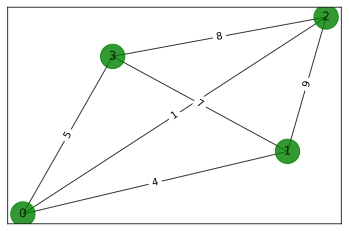

In [6]:
G = nx.Graph() # creating an instance

n = 4 # number of nodes

V = np.arange(0, n, 1) # vertices
G.add_nodes_from(V)

E = [(0, 1, 2), (0, 2, 5), (0, 3, 0.25), (1, 2, 3), (2, 3, 1.0), (1, 3, 0.30)] # initialising nodes with weighted edges
# E = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)] # nodes with constant weight = 1.0
G.add_weighted_edges_from(E)

for (u, v, w) in G.edges(data=True): # generates graphs randomly every time it's run :)
    w['weight'] = np.random.randint(0,10)

# generating the plot for the graph

colors = ['g' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

###Creating the QAOA state

$$\begin{align}QAOA-State \end{align}$$

$$\begin{align} \left| \gamma \beta \right> &= \prod_{q=1}^p e^{-i \beta_q B} e^{-i \gamma_q H_c} \left(H \otimes \cdots \otimes H \right) \left( |0\rangle \otimes \cdots \otimes |0\rangle \right), \end{align}$$


where B, the mixing operator, is defined as:
$$\begin{align}B = \sum_k X_k.
\end{align}$$ 


- Implementation of $e^{-i\gamma \frac{1}{2}(1-Z_n \otimes Z_m)}$

${\displaystyle U(C,\gamma) = e^{-i \gamma C} = \prod_{\alpha} e^{-i \gamma C_{\alpha}} }$, where $C_{\alpha}$ are the cost operators.

- Implementation of $e^{-i\beta X}$

${\displaystyle U(B,\beta) = e^{-i \beta B} = \prod_{j} e^{-i \beta B_{j}} }$, where $B_{j}$ are the driver operators and $|{s}\rangle$ is the initial state.

And finally: $|{\beta, \gamma}\rangle$ = $U(B, \beta) U(C, \gamma) |{s}\rangle$


In [7]:
def create_state(gammas, betas, p=1):
    '''
    In this function, we generate the state |gamma, beta> for an order p. 
    We can customise the value of order p.
    '''

    # creating a quantum circuit
    qc = QuantumCircuit(n, n)

    qc.h(range(0, n)) # applying the Hadamard gate to all qubits
    qc.barrier()

    # preparing the qaoa trial state
    for k in range(p):

        for edge in G.edges():
            i,j = edge[0], edge[1]

            # U(gamma)
            qc.u1(gammas[k], i)
            qc.u1(gammas[k], j)
            qc.cu1(-2 * gammas[k], i, j)
            qc.barrier()
        
        # U(beta)
        qc.rx(2 * betas[k], range(n))
        qc.barrier()
    
    qc.measure(range(n),range(n)) # measuring the circuit
    
    return qc

####Linear transform 

In [8]:
def linear_transform(x):
    '''
    In this function, we map the bitstring values of {0, 1} --> {-1, 1}
    through a simple linear transform of f(x) = 2 * x - 1 to simplify 
    calculations and get the desired results. 
    
    It returns a numpy array with -1 and 1 entries with intuition behind it 
    as described in https://lucaman99.github.io/new_blog/2020/mar16.html

    x   --> bitstring that contains 0 or 1
    x_1 --> bitstring that contains -1 or 1 after it undergoes linear transform
    '''
    
    n = len(x) # length of bitstring
    x_1 = np.zeros(n) # creating an empty array to put in transformed values 
    
    for i in range(n):
        x_1[i] = 2 * int(x[i]) - 1 # linear transform
    
    return x_1

####Cost Function

The total cost of our solution is:

$C_{total} = \sum C_{ij} = \sum \frac{1}{2} w_{ij} (1 - z_i z_j) $,

where $w_{ij}$ is the weight of given edge and the sum goes through all the pairs of nodes and values $z_i$ are equal to 1 if the given node is in the set $A$ and -1 if it's in the $B$. 

We can construct a matrix (Hamiltonian), which corresponds to this cost function using only Pauli operators:

$H_{cost} = \sum \frac{1}{2} w_{ij} (\mathbb{1} - \sigma^z_i \sigma^z_j$)

In [9]:
def cost_function(G, x):
    '''
    In this function, we compute the cost function for the weighted max-cut
    problem:  
    
    C_total = sigma_{i,j} [ 0.5 * w{i,j} * (1 - x{i} * x{j}]
    In the above equation, x{i} and x{j} are -1 or 1 after linear transform.
    
    x    --> bitstring that contains 0 or 1
    x_1  --> bitstring that contains -1 or 1 after it undergoes linear transform
    G    --> graph object
    cost --> value of cost
    k    --> weight of the edges
    '''

    x_1 = linear_transform(x)
    
    cost = 0.0 # intiating value of cost function to 0.0
    for (i, j, k) in G.edges(data=True): 
        cost += 0.5 * k['weight'] * (1.0 - x_1[i] * x_1[j]) # computing the cost function
    
    return cost

In [10]:
for (i, j, k) in G.edges(data=True): 
    print(k['weight']) # value of weights

4
1
5
9
7
8


####Computing the expectation value

Expectation value of the created state on the cost Hamiltonian,

$$\begin{align}
F(\gamma,\beta) = \langle \gamma \beta|H_c|\gamma \beta \rangle.
\end{align}$$

In [11]:
def expectation_value(G, gammas, betas, p=1, num_shots=100):
    '''
    In this function, we compute the expectation value of the cost hamiltonian: 
    
    H_c = 0.5 * sigma_{n,m} [ 1.0 - Z_n * Z_m ]
    on the state |gamma, beta> produced by the create_state function above 
    
    f(gammas, betas) = <gammas betas | H_c | gammas betas> 
    
    G         --> graph object
    exp_value --> expectation value of the cost hamiltonian
    p         --> order
    num_shots --> number of shots to compute the expectation value
    '''

    exp_value = 0.0
    
    backend = Aer.get_backend("qasm_simulator") # using the backend simulator
    
    qc = create_state(gammas, betas, p)
    simulation = execute(qc, backend=backend, shots=num_shots)
    
    results = simulation.result()
    counts = results.get_counts()
    
    for x in counts:
        exp_value += cost_function(G, x) * (counts[x] / num_shots)
    
    return exp_value

####Creating an expectation function to optimise

In [12]:
p = 2 # setting the order

def f_to_optimise(z):
    '''
    In this function, we create our expectation value function that the scipy 
    optimizer can optimize.
    '''
    
    n = len(z)
    gammas = z[0 : int(n/2)]
    betas  = z[int(n/2) : n]
    
    f = - expectation_value(G, gammas, betas, p=int(n/2), num_shots=1000)
    
    return f

# initializing the set of gammas and betas
gammas = 2.0 * np.pi * np.random.uniform(0, 1, p)
betas = np.pi * np.random.uniform(0, 1, p)

# minimising the objective function using the Nelder-Mead algorithm
# can try minimising with BFGS or Newton-CG methods too
z_0 = np.concatenate((gammas, betas))
sol = minimize(f_to_optimise, z_0, method='nelder-mead', options={'xatol': 1e-2, 'disp': False})

print('-' * 100)
print('QAOA order (p): ', p)
print('Solution: ', sol.x)
print('-' * 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.


----------------------------------------------------------------------------------------------------
QAOA order (p):  2
Solution:  [5.10817421 1.21639823 2.91194044 1.13051906]
----------------------------------------------------------------------------------------------------



 --- Simulation Results --- 

The approximate solution is x* = 0101 with C(x*) = 26
Maximum energy distributions  ['0101', '1010']
Maximum observed energy:  26.0
The cost function is distributed as: 



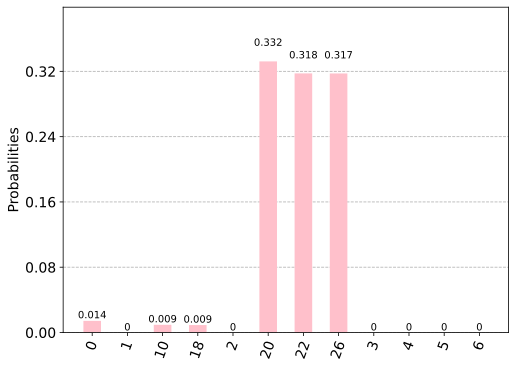

In [27]:
num_shots  = 100000

# extracting the optimal parameters for the gamma and beta parameters
gammas_max = sol.x[0 : p] 
betas_max  = sol.x[p : 2 * p]

# using the backend simulator
backend = Aer.get_backend("qasm_simulator")

# generating the qaoa states and sampling the state in the computational basis
qc = create_state(gammas_max, betas_max, p=p)
simulation = execute(qc, backend=backend, shots=num_shots)

# retrieving the results from the qaoa
qaoa_results = simulation.result()
counts = qaoa_results.get_counts()

# converting the observed bit-strings into a list 
x_observed = list(counts.keys())
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges()) + 1):
    hist[str(k)] = hist.get(str(k), 0)

for x_sample in x_observed:

    # using the sampled bit string x to compute the cost
    x         = [int(n) for n in list(x_sample)]
    tmp_eng   = cost_function(G, x)
    
    # computing the expectation value and energy distribution
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[x_sample]
    
    # saving best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = x_sample
        max_C[1] = tmp_eng

# computing the observed energies and keep record of the best solutions
energy_distribution = []

for x in counts:
      energy_distribution.append(cost_function(G, x))

# getting the maximum observed energy
max_energy = max(energy_distribution)

max_energy_distributions = []

for j in range(len(counts)):
    E_j = energy_distribution[j]
    
    if(E_j == max_energy):
        max_energy_distributions.append(x_observed[j])

print('\n --- Simulation Results --- \n')
print('The approximate solution is x* = %s with C(x*) = %d' % (max_C[0], max_C[1]))
print('Maximum energy distributions ', max_energy_distributions)
print('Maximum observed energy: ', max_energy)
print('The cost function is distributed as: \n')

plot_histogram(hist, figsize = (8,6), bar_labels = True, color = 'pink') 

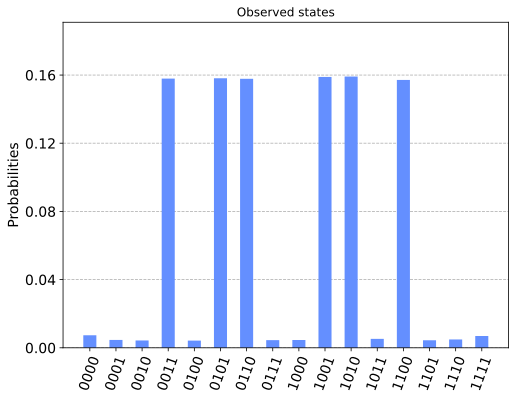

In [21]:
# bit-strings corresponding to the maximium amplitudes
plot_histogram(qaoa_results.get_counts(), 
              title='Observed states',
              figsize=(8, 6),
              bar_labels=False)

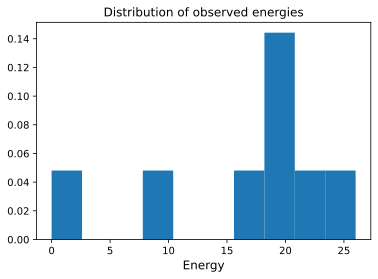

In [29]:
plt.title('Distribution of observed energies', size=12)
plt.xlabel('Energy', size=12)
plt.hist(energy_distribution, density=True)
plt.show()

####Plotting solution to weighted max-cut problem

----------------------------------------------------------------------------------------------------
The solution(s) to our weighted max-cut problem: 
----------------------------------------------------------------------------------------------------


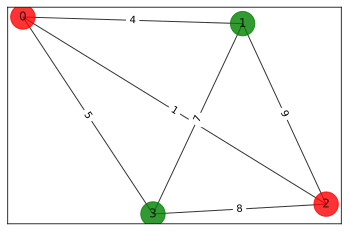

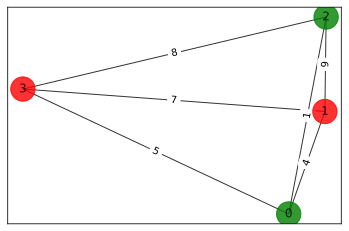

In [30]:
def return_colors(x):
    '''
    In this function, we map the bit string to 2 different colours for
    visualization of the solution to the weighted max-cut problem
    
    x --> 
    c -->
    k -->
    '''

    colors = []
    
    for i in range(len(x)):
        
        k = x[i]
        
        if(k == '1'):
            colors.append('g') # green nodes
        elif(k == '0'):
            colors.append('r') # red nodes
    
    return colors


print('-' * 100)
print('The solution(s) to our weighted max-cut problem: ')
print('-' * 100)

# plotting all the solutions to the weighted maxcut problem

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

for i in range(len(max_energy_distributions)):
    colors = return_colors(max_energy_distributions[i])
    pos = nx.spring_layout(G)
    draw_graph(G, colors, pos)
    plt.show()

####Verifying QAOA with brute force method

In [33]:
perms= ["".join(seq) for seq in itertools.product("01", repeat=n)]

scores = []

for x in perms:
    E_x = cost_function(G, x)
    scores.append(E_x)

# finding the maximum score
max_E = np.max(scores)

max_strings = []

# finding all the energies where max_E is maximum and storing the results
for k in range(len(scores)):

    score_k = scores[k]
    x = perms[k]
    
    if(score_k == max_E):
        max_strings.append(x)

print('-' * 100)
print('Maximum Energy: ', max_E,'\n')
print('Brute force solutions: {} \n'.format(len(max_strings)), max_strings, '\n')
print('QAOA solutions: {} \n'.format(len(max_energy_distributions)), max_energy_distributions)
print('-' * 100)


# checking if all of the solutions from the QAOA and the brute force method match
count = 1
wrong_solutions = 0
for s in max_energy_distributions:
    
    if(s in max_strings):
        count += 1
    else:
        wrong_solutions += 1


if(count - 1 == len(max_strings)):
    print('Yayy, the QAOA solution(s) and the brute-force methods match! :)')
    print('-' * 100)
else:
    print('The QAOA algorithm is missing {} solutions.:/'.format(len(max_strings)-count))
    print('The number of incorrect solutions is: {}'.format(wrong_solutions))
    print('-' * 100)

----------------------------------------------------------------------------------------------------
Maximum Energy:  26.0 

Brute force solutions: 2 
 ['0101', '1010'] 

QAOA solutions: 2 
 ['0101', '1010']
----------------------------------------------------------------------------------------------------
Yayy, the QAOA solution(s) and the brute-force methods match! :)
----------------------------------------------------------------------------------------------------
